## Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [61]:
def write_pvalue(p_value):
    if p_value < 0.001:
        return "<0.001"
    elif p_value < 0.01:
        return f"{p_value:.3f}"
    elif p_value < 0.1:
        return f"{p_value:.2f}"
    else:
        return f"{p_value:.1f}"

## Data

In [55]:
# Time spent in the clinic per track_id
tt = pd.read_csv("../data-clean/tracking/time-in-clinic.csv")

# Mapping dates to intervention periods
map_dates = pd.read_csv("../data-clean/mapping_dates_interventions.csv")

# Clinical data
clin = pd.read_csv("../data-clean/clinical/tb_cases.csv")
tb_patients = clin[clin['tb_status'].isin(['diagnosed', 'presumptive'])].groupby('date').size().reset_index(name='tb_patients')

# Air change rates
aer = pd.read_csv('../data-clean/environmental/air-exchange-rate.csv')
aer_272D2 = aer[aer['device'] == 'Aranet4 272D2']

# Merge data
merged_df = pd.merge(tt, map_dates, on='date', how='left')
merged_df = pd.merge(merged_df, tb_patients, on='date', how='left')
merged_df = pd.merge(merged_df, aer_272D2, on='date', how='left')
print(merged_df)

        track_id  total_time_in_clinic        date study_phase  tb_patients  \
0         217625                138.00  2024-06-26    Baseline           24   
1         217632                 14.48  2024-06-26    Baseline           24   
2         217640                 88.00  2024-06-26    Baseline           24   
3         217641                607.52  2024-06-26    Baseline           24   
4         217643                 48.48  2024-06-26    Baseline           24   
...          ...                   ...         ...         ...          ...   
672285    197890               6492.96  2024-08-06    Baseline            4   
672286    197895                 11.52  2024-08-06    Baseline            4   
672287    197896                 35.44  2024-08-06    Baseline            4   
672288    197897                 34.96  2024-08-06    Baseline            4   
672289    197900                 26.48  2024-08-06    Baseline            4   

               device   aer_tmb      Cr_tmb   aer_s

## Modelling

In [68]:
# Filter movements >5min
merged_df = merged_df[merged_df['total_time_in_clinic'] > 300]

# Compute the new column t
merged_df['t'] = merged_df['total_time_in_clinic'] / 3600

# Compute the new column I
merged_df['I'] = merged_df['tb_patients'] * merged_df['t'] / 12

# Compute the new column P
q = 2
p = 0.5
dist_eff = 1
vol_eff = (dist_eff**2 * 3) + 0.5 * (dist_eff**2 * 1.4)
merged_df['P'] = 1 - np.exp(-merged_df['I'] * q * 1 * p / (merged_df['aer_tmb'] * vol_eff))

(merged_df['P'] * 100).describe().round(2)

count    162750.00
mean          1.32
std           1.81
min           0.04
25%           0.38
50%           0.74
75%           1.53
max          42.58
Name: P, dtype: float64

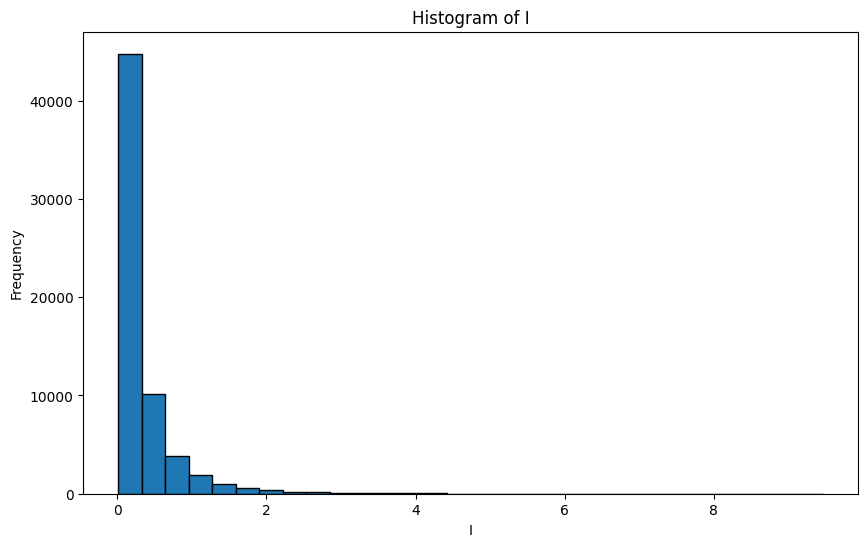

In [69]:
# Plot a histogram of baseline_df['I']
plt.figure(figsize=(10, 6))
plt.hist(baseline_df['I'], bins=30, edgecolor='black')
plt.xlabel('I')
plt.ylabel('Frequency')
plt.title('Histogram of I')
plt.show()

### Translate contact reduction into new risk

In [78]:
def calculate_new_risk(P, OR, IRR):
    """
    Calculate the hypothetical new risk (P_new) based on the initial risk (P),
    Odds Ratio (OR) for a doubling of contacts, and the observed Incidence Risk Ratio (IRR).
    
    Parameters:
    - P: float, initial risk
    - OR: float, odds ratio for doubling contacts
    - IRR: float, observed incidence risk ratio
    
    Returns:
    - P_new: float, adjusted risk after incorporating IRR
    """
    # Step 1: Calculate adjusted risk based on OR
    odds = P / (1 - P)  # Original odds
    adjusted_odds = odds * OR  # Adjusted odds
    P_adjusted = adjusted_odds / (1 + adjusted_odds)  # Adjusted risk

    # Step 2: Scale the difference between P_adjusted and P using IRR and OR
    ln_IRR = math.log(IRR)
    ln_OR = math.log(OR)
    scaling_factor = ln_IRR / ln_OR

    # Calculate the new risk P_new
    P_new = P + (P_adjusted - P) * scaling_factor
    return P_new

# Example usage
P = 0.1  # Initial risk
OR = 1.17  # Odds Ratio for doubling contacts
IRR_i1 = 0.92
IRR_i2 = 0.89


# Iterate over merged_df and compute the new columns
for index, row in merged_df.iterrows():
    P = row['P']
    if row['study_phase'] == "Baseline":
        merged_df.at[index, 'P_b'] = P
        merged_df.at[index, 'P_i1'] = calculate_new_risk(P, OR, IRR_i1)
        merged_df.at[index, 'P_i2'] = calculate_new_risk(P, OR, IRR_i2)
    elif row['study_phase'] == "First intervention":
        merged_df.at[index, 'P_b'] = calculate_new_risk(P, OR, 1 / IRR_i1)
        merged_df.at[index, 'P_i1'] = P
        merged_df.at[index, 'P_i2'] = calculate_new_risk(P, OR, IRR_i2 / IRR_i1)
    elif row['study_phase'] == "Second intervention":
        merged_df.at[index, 'P_b'] = calculate_new_risk(P, OR, 1 / IRR_i2)
        merged_df.at[index, 'P_i1'] = calculate_new_risk(P, OR, IRR_i1 / IRR_i2)
        merged_df.at[index, 'P_i2'] = P

In [79]:
print("Baseline risk:\n")
print((100 * merged_df['P_b']).describe().round(2)[['50%', '25%', '75%']])
print("\nFirst intervention risk:\n")
print((100 * merged_df['P_i1']).describe().round(2)[['50%', '25%', '75%']])
print("\nSecond intervention risk:")
print((100 * merged_df['P_i2']).describe().round(2)[['50%', '25%', '75%']])

Baseline risk:

50%    0.79
25%    0.40
75%    1.65
Name: P_b, dtype: float64

First intervention risk:

50%    0.72
25%    0.37
75%    1.51
Name: P_i1, dtype: float64

Second intervention risk:
50%    0.70
25%    0.35
75%    1.46
Name: P_i2, dtype: float64


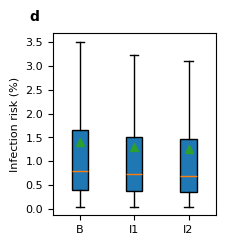

In [80]:
import matplotlib.pyplot as plt

# Convert P, P_i1, and P_i2 to percentages
merged_df['P_b_percent'] = merged_df['P_b'] * 100
merged_df['P_i1_percent'] = merged_df['P_i1'] * 100
merged_df['P_i2_percent'] = merged_df['P_i2'] * 100

# Create a DataFrame for the boxplot
boxplot_data = [merged_df['P_b_percent'], merged_df['P_i1_percent'], merged_df['P_i2_percent']]

# Create the boxplots
fig, ax = plt.subplots(figsize=(5.33 / 2.54, 6 / 2.54))
ax.boxplot(boxplot_data, patch_artist=True, showmeans=True, showfliers=False)
ax.set_xticklabels(['B', 'I1', 'I2'], fontsize=8)
ax.set_ylabel('Infection risk (%)', fontsize=8)
ax.tick_params(axis='y', labelsize=8)

# Set the title on top at the left end of the plot
fig.suptitle('d', fontsize=10, fontweight='bold', x=0.01, ha='left')

plt.show()

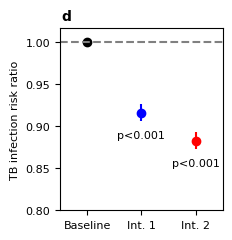

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel

# Compute the risk ratios directly for paired values
def compute_paired_risk_ratio_and_ci(data1, data2, alpha=0.05):
    ratios = data2 / data1
    mean_ratio = np.mean(ratios)
    se = np.std(ratios) / np.sqrt(len(ratios))
    z = 1.96  # for 95% confidence interval
    lower_bound = mean_ratio - z * se
    upper_bound = mean_ratio + z * se
    return mean_ratio, lower_bound, upper_bound

# Compute the risk ratios and confidence intervals
mean_ratio_first, lower_first, upper_first = compute_paired_risk_ratio_and_ci(merged_df['P_b'], merged_df['P_i1'])
mean_ratio_second, lower_second, upper_second = compute_paired_risk_ratio_and_ci(merged_df['P_b'], merged_df['P_i2'])

# Compute the p-values
p_value_first_vs_baseline = ttest_rel(merged_df['P_b'], merged_df['P_i1']).pvalue
p_value_second_vs_baseline = ttest_rel(merged_df['P_b'], merged_df['P_i2']).pvalue

# Format the p-values
formatted_p_value_first_vs_baseline = write_pvalue(p_value_first_vs_baseline)
formatted_p_value_second_vs_baseline = write_pvalue(p_value_second_vs_baseline)

# Create the plot
fig, ax = plt.subplots(figsize=(5.33 / 2.54, 6 / 2.54))

# Plot the baseline point
ax.plot(1, 1, 'o', color='black', label='Baseline')

# Plot the risk ratios with error bars
art_error_ext = 0.01
ax.errorbar(2, mean_ratio_first, yerr=[[mean_ratio_first - lower_first + art_error_ext], [upper_first - mean_ratio_first + art_error_ext]], fmt='o', color='blue', label='First Intervention')
ax.errorbar(3, mean_ratio_second, yerr=[[mean_ratio_second - lower_second + art_error_ext], [upper_second - mean_ratio_second + art_error_ext]], fmt='o', color='red', label='Second Intervention')

# Add a horizontal dashed line at y=1
ax.axhline(y=1, color='gray', linestyle='--')

# Set the x-axis labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Baseline', 'Int. 1', 'Int. 2'], fontsize=8)

# Set the y-axis label
ax.set_ylabel('TB infection risk ratio', fontsize=8)
ax.tick_params(axis='y', labelsize=8)

# Add p-values as text slightly above the maximum of each line inside the plot
ax.text(2, upper_first - 0.03, f'p{formatted_p_value_first_vs_baseline}', fontsize=8, ha='center')
ax.text(3, upper_second - 0.03, f'p{formatted_p_value_second_vs_baseline}', fontsize=8, ha='center')

# Set the y-axis limit to slightly above the maximum of the error bars
y_max = max(upper_first, upper_second) + 0.1
ax.set_ylim(0.8, y_max)

# Slightly increase the margin of the x-axis on the left and right
ax.set_xlim(0.5, 3.5)

# Set the title
plt.title('d', fontsize=10, fontweight='bold', x=0.01, ha='left')

# Show the plot
plt.savefig('../results/crude-infection-risk.png', dpi=300, bbox_inches='tight')
plt.show()